# Ensemble Experiments

Code to answer the following question(s):

1. Do safe base learners imply safe ensembles?
1. Do safe ensembles imply safe base learners?

The question is answered via comparing results from Decision Trees with those from Random Forests where the key hyper-parameters (`min_samples_split`, `min_samples_leaf`, `max_depth`) are the same. I.e. we therefore have the comparison of the base learner and the ensemble, where the hyper-parameters match. The results show that you _can_ get more risky ensembles than base learners in this case.

To further investigate, one of the worst examples (decision tree mia AUC = 0.5, RF AUC = 0.9) was extracted and trained. The attack metrics were computed. Then each individual tree was assessed. All of the individual trees are safe but the ensemble clearly isn't.

At the end, a small example is presented that shows how easy it is to embed a risky model into an ensemble which leaves the ensemble still looking safe. I.e. showing that safe ensemble does not imply safe base learner. This is done in a slightly hacky way, by training a safe RF and then adding an extra estimator. When we average over the probabilities, we see a modest increase in the attack susceptibility of the new ensemble. And it would be possible to water this down further by increasing the number of estimators in the original (safe) ensemble.

In [76]:
from data_preprocessing.data_interface import get_data_sklearn
import logging
import pandas as pd
import numpy as np

logging.basicConfig(level = logging.INFO)

import pylab as plt
%matplotlib inline
logging.basicConfig(level=logging.INFO)
font = {'size': 18}
plt.rc('font', **font)

from attacks.scenarios import split_target_data, worst_case_mia
from attacks.metrics import get_metrics
from sklearn.ensemble import RandomForestClassifier


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


Load the D-tree and RandomForest results. We only keep the non-bootstrap results as these are the most risky.

In [43]:
# Load dtree results
dtr = pd.read_csv("results/from_aws/DecisionTreeClassifier_results_corrected.csv")
rfr = pd.read_csv("results/from_aws/RandomForest_results_corrected.csv")
rfr = rfr[rfr['bootstrap'] == False]
all_res = pd.concat((dtr, rfr), ignore_index=True)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


Plot decision tree versus random forest where each point is the same hyper-parameters. This allows us to quickly see if there are hyper-param sets that produce safe trees, but unsafe forests.

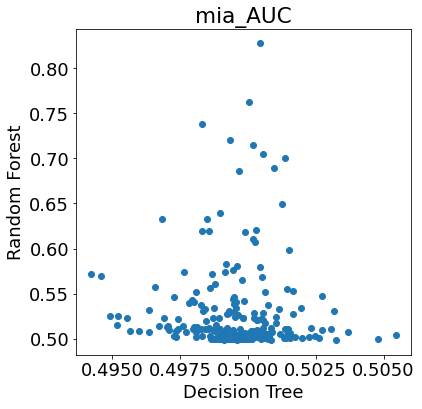

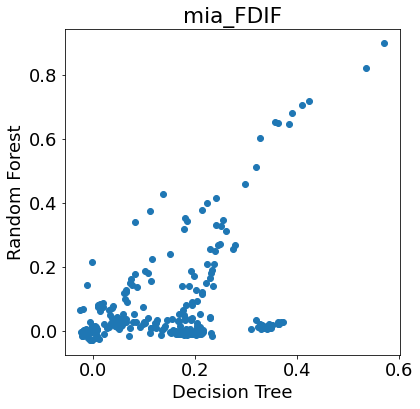

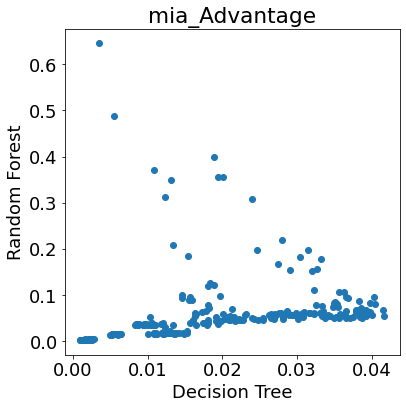

In [78]:
metrics_to_plot = [
    'mia_AUC',
    'mia_FDIF',
    'mia_Advantage'
]
for metric in metrics_to_plot:
    group_pars = [
        'target_classifier',
        'dataset',
        'min_samples_split',
        'min_samples_leaf',
        'max_depth'
    ]
    # Average the chosen metric over all things except target_classifier, dataset, and the three relevant hyper-pars
    tt = all_res.groupby(group_pars).aggregate(mean_metric=(metric, np.mean))
    tt.reset_index(inplace=True)
    
    # Pivot by the same columns, without target_classifier. This will pivot into a dataframe with
    # one column for D-tree and one for RF with rows with matching values
    pivot_index = group_pars[1:]
    ptt = tt.pivot(index=pivot_index, columns="target_classifier", values="mean_metric")
    ptt.reset_index(inplace=True)

    # Plot for this metric and save
    plt.figure(figsize=(6, 6))
    plt.scatter(ptt['DecisionTreeClassifier'], ptt['RandomForestClassifier'])
    plt.xlabel('Decision Tree')
    plt.ylabel('Random Forest')
    plt.title(metric)
    plt.savefig(f'ensemble_{metric}.png')

## Do safe base learners imply safe ensembles?

Now look in more detail at some specific examples - in particular the example that has mia AUC over 0.8.

Same pivoting as above, but just for mia_AUC

In [79]:
metric = 'mia_AUC'
tt = all_res.groupby(group_pars).aggregate(mean_metric=(metric, np.mean))
tt.reset_index(inplace=True)
pivot_index = group_pars[1:] # skip target class
ptt = tt.pivot(index=pivot_index, columns="target_classifier", values="mean_metric")
ptt.reset_index(inplace=True)
ptt['metric_diff'] = ptt['RandomForestClassifier'] - ptt['DecisionTreeClassifier']
ptt_sub = ptt[(ptt['RandomForestClassifier'] > 0.8)]
print(ptt_sub.head())

target_classifier                dataset  min_samples_split  min_samples_leaf  \
2                  in-hospital-mortality                  2                 1   

target_classifier  max_depth  DecisionTreeClassifier  RandomForestClassifier  \
2                       10.0                0.500465                0.827144   

target_classifier  metric_diff  
2                     0.326679  


Using the hyper-params identified above, train the random forest and simulate a (worst case) attack

In [118]:
min_samples_split = 2
min_samples_leaf = 1
max_depth = 10.0
X, y= get_data_sklearn('in-hospital-mortality')
X_target, X_train, X_test, y_target, y_train, y_test = split_target_data(X.values, y.values.flatten())
rf = RandomForestClassifier(
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_depth=10,
    bootstrap=False
)
rf.fit(X_target, y_target)
mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(rf, X_target, X_test)
rf_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)
metrics = [m.split('_')[1] for m in metrics_to_plot]
for m in metrics:
    print(m, rf_metrics[m])


INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:DATASET FOLDER = c:\Users\simonr04\git\GRAIMatter\data


AUC 0.9875
FDIF 1.0
Advantage 0.95833333


Assess the base learners for the same metrics. They are accessible in the `estimators_` class attribute

In [89]:
base_learner_metrics = {m: [] for m in metrics}
for i, base_learner in enumerate(rf.estimators_):
    if i % 10 == 0:
        print(i)
    mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(base_learner, X_target, X_test)
    e_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)
    for m in metrics:
        base_learner_metrics[m].append(e_metrics[m])

0
10
20
30
40
50
60
70
80
90


Plot histograms of the metrics, showing the ensemble value as a dashed line.

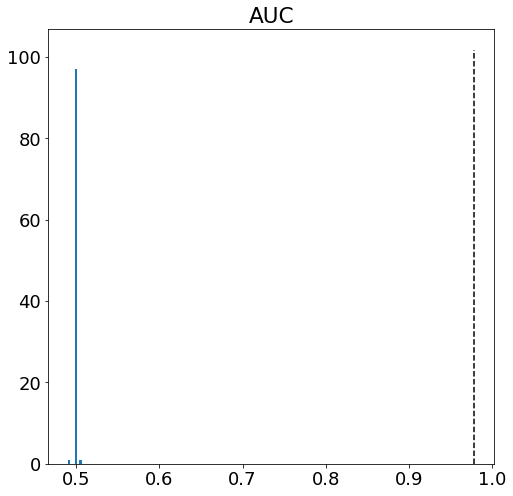

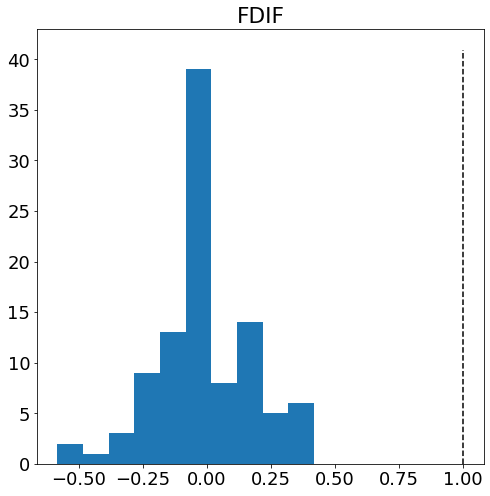

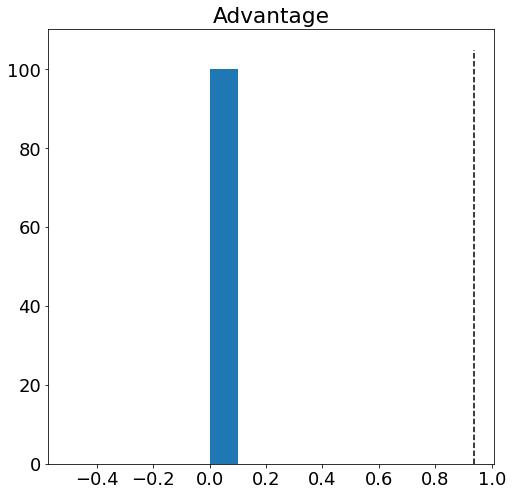

In [91]:
for m in metrics:
    plt.figure(figsize=(8, 8))
    plt.hist(base_learner_metrics[m])
    plt.title(m)
    yl = plt.ylim()
    plt.plot([rf_metrics[m], rf_metrics[m]], yl, 'k--')
    plt.savefig(f'base_hist_{m}.png')

## Do safe ensembles imply safe base learners?

A contrived example where we add a bad model to a safe ensemble and see that the new ensemble has a much lower attack susceptibility than the bad model.

In [132]:
class HackyForest():
    '''
    Class that enables a random forest to have another estimator added to it.
    Used to demonstrate that we can add a really disclosive model (in this case a RF) to
    an ensemble (another RF) with very little change to its output
    '''
    def __init__(self, rf, bad_classifier):
        self.rf = rf
        self.bad_classifier = bad_classifier
    
    def predict_proba(self, X):
        probs = self.rf.predict_proba(X)
        extra_probs = self.bad_classifier.predict_proba(X)
        probs = probs * rf.n_estimators
        probs += extra_probs
        probs /= (rf.n_estimators + 1)
        return probs
    

In [136]:
# Fit a bad random forest and report attack metrics
min_samples_split = 2
min_samples_leaf = 1
max_depth = 10
X, y= get_data_sklearn('in-hospital-mortality')
from attacks.scenarios import split_target_data, worst_case_mia
from attacks.metrics import get_metrics
from sklearn.ensemble import RandomForestClassifier
X_target, X_train, X_test, y_target, y_train, y_test = split_target_data(X.values, y.values.flatten())
bad_rf = RandomForestClassifier(
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    bootstrap=False
)
bad_rf.fit(X_target, y_target)
mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(bad_rf, X_target, X_test)
bad_rf_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)
print("Bad RF metrics")
for m in metrics:
    print(m, bad_rf_metrics[m])

# Fit a safe random forest and report attack metrics
min_samples_split = 10
min_samples_leaf = 10
max_depth = 10
safe_rf = RandomForestClassifier(
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    bootstrap=True
)
safe_rf.fit(X_target, y_target)
mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(safe_rf, X_target, X_test)
safe_rf_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)
print()
print("Safe RF metrics")
for m in metrics:
    print(m, safe_rf_metrics[m])

# Combine them into a new ensemble - and report the metrics
hf = HackyForest(safe_rf, rf)
mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(hf, X_target, X_test)
hf_rf_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)

print()
print("Meta combination metrics")
for m in metrics:
    print(m, hf_rf_metrics[m])


INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:DATASET FOLDER = c:\Users\simonr04\git\GRAIMatter\data


Bad RF metrics
AUC 0.99280791
FDIF 1.0
Advantage 0.9787234

Safe RF metrics
AUC 0.50194786
FDIF 0.08333333333333326
Advantage 0.053341329999999965

Meta combination metrics
AUC 0.58630952
FDIF 0.08333333333333326
Advantage 0.20119047


In [140]:
all_estimators = safe_rf.estimators_ + [rf]
base_learner_metrics = {m: [] for m in metrics}
for i, base_learner in enumerate(all_estimators):
    if i % 10 == 0:
        print(i)
    mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(base_learner, X_target, X_test)
    e_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)
    for m in metrics:
        base_learner_metrics[m].append(e_metrics[m])

0
10
20
30
40
50
60
70
80
90
100


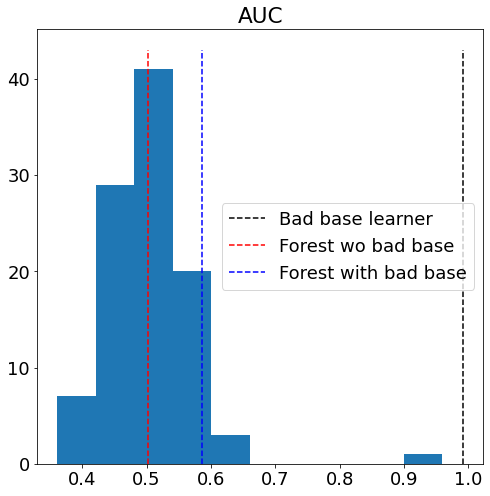

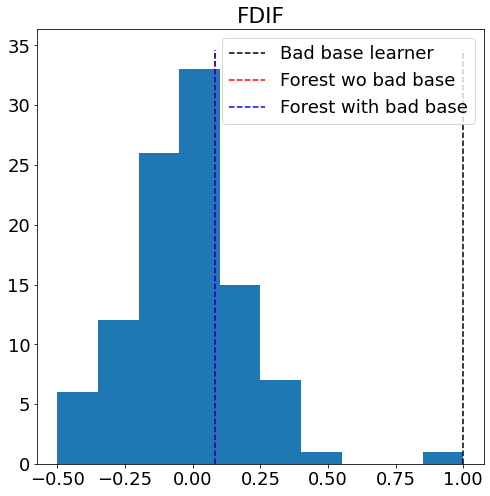

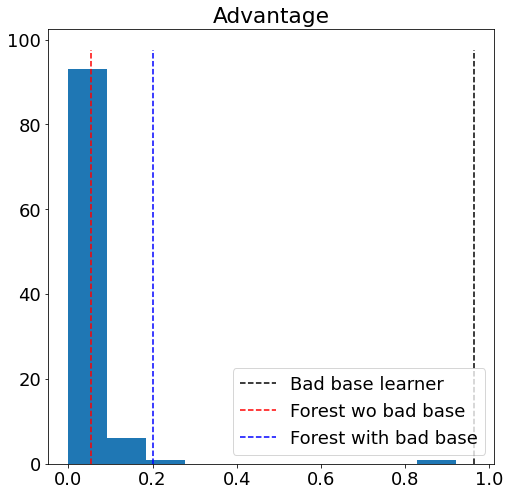

In [142]:
for m in metrics:
    plt.figure(figsize=(8, 8))
    plt.hist(base_learner_metrics[m])
    plt.title(m)
    yl = plt.ylim()
    plt.plot([rf_metrics[m], rf_metrics[m]], yl, 'k--', label='Bad base learner')
    plt.plot([safe_rf_metrics[m], safe_rf_metrics[m]], yl, 'r--', label='Forest wo bad base')
    plt.plot([hf_rf_metrics[m], hf_rf_metrics[m]], yl, 'b--', label='Forest with bad base')
    plt.legend()
    plt.savefig(f'base_hist_{m}.png')

### An even more contrived example

Take the bad model above, and make an ensemble with it and another model that predicts 1-it. This, as an ensemble, is totally safe, but the individual model is bad.

In [143]:
class Contrived():
    def __init__(self, bad_model):
        self.bad_model = bad_model
    def predict_proba(self, X):
        probs = self.bad_model.predict_proba(X)
        probs += 1 - probs # assumes binary classification
        return probs

In [145]:
cr = Contrived(bad_rf)
mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(cr, X_target, X_test)
cr_rf_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)

print()
print("Meta combination metrics")
for m in metrics:
    print(m, cr_rf_metrics[m])



Meta combination metrics
AUC 0.5
FDIF -0.3333333333333333
Advantage 0.0
